In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from tqdm.auto import tqdm
import imageio
import sys

# 3D photon gun

This code is to simulate Monte Carlo ray tracing for iLiDAR with GHz and acoustics

In [2]:
# For visualising a cuboid in matplotlib 3D
def cuboid_data(o, size=(1,1,1)):
    """
    

    Parameters
    ----------
    o : 3D vector-like, starting position of the cuboid
    size : 3D vector-like, size of the box. The default is (1,1,1).

    Returns
    -------
    list of arrays, namely the x,y and z coordinates of the cuboid surface.

    """
    # code taken from
    # https://stackoverflow.com/a/35978146/4124317
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the length, width, and height
    l, w, h = size
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  
         [o[1], o[1], o[1], o[1], o[1]],          
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]   
    z = [[o[2], o[2], o[2], o[2], o[2]],                       
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],   
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],               
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]               
    return np.array(x), np.array(y), np.array(z)

### Geometry of the room


AttributeError: 'Poly3DCollection' object has no attribute '_facecolors3d'

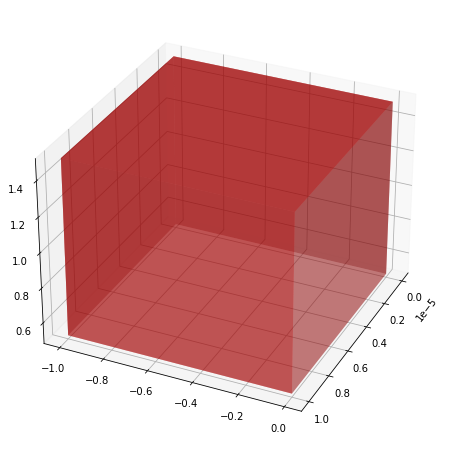

In [3]:
# I create the dimensions of the room. It will be a cuboid room,
# starting at x = 0, y = -2, z=-3.5, with dimensions: 4, 4, 7 along x,y,z respectively.
# The 6 walls will be at:
# x =  0
# x =  xend (4)
# y = -yend (-3.5)
# y =  yend (3.5)
# z = -zend (-3.5)
# z =  zend (3.5)

xend = 4; 
yend = 3.5;
zend = 3.5;
# Wall top (in x-y plane)
xti = 0; xtf = xend; 
yti = -yend; ytf = yend;
zt = zend;  

# Wall bottom (in x-y plane)
xbi = 0; xbf = xend; 
ybi = -yend; ybf = yend;
zb = -zend;  

#  Wall left (in x-z plane)
xli = 0; xlf = xend; 
yl = -yend
zli = -zend; zlf = zend;

# Wall right (in x-z plane)
xri = 0; xrf = xend; 
yr = yend
zri = -zend; zrf = zend;

# Wall near (in y-z plane)
xn = 0
yni = -yend; ynf = yend
zni = -zend; znf = zend;

#  Wall far (in y-z plane)
xf = xend
yfi = -yend; yff = yend
zfi = -zend; zff = zend;

# Sensor/emitter: I choose a cuboid sensor. Only waves coming from far to
# near to the sensor will be detected. The sensor is placed at xsens_i,
# ysens_i, zsens_i and waves are also emitted from there. 
dim_sens = 1;
xsens_i = 0; sensx = 1E-5; 
ysens_i = -1; sensy = dim_sens; 
zsens_i = dim_sens/2; sensz = dim_sens;

# Object
Lx = 1; 
Ly = 1; 
Lz = 5;
xob_i = 3;
yob_i = 0.5; 
zob_i = -zend; 

# Camera (just a point)
xcam = xsens_i
ycam = ysens_i
zcam = zsens_i
Lcam = 0.2

# Get instance of Axis3D
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection="3d")
ax.view_init(azim=25,elev=30)
X, Y, Z = cuboid_data((xsens_i,ysens_i,zsens_i), (sensx,sensy,sensz))
surf = ax.plot_surface(X, Y, Z,color='Red',label='sensor',alpha=0.3)  #sensor
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
X, Y, Z = cuboid_data((xcam,ycam,zcam), (-Lcam, Lcam,Lcam))
surf = ax.plot_surface(X, Y, Z,color='black',label='camera',alpha=0.3)  #camera
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
X, Y, Z = cuboid_data((xob_i,yob_i,zob_i), (Lx,Ly,Lz))
surf = ax.plot_surface(X, Y, Z,color='blue',label='object',alpha=1,shade=False)  #object
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d
X, Y, Z = cuboid_data((0,-yend,-zend), (4,7,7))
surf = ax.plot_surface(X, Y, Z,color='grey',label='room',alpha=0.15)  #room
surf._facecolors2d=surf._facecolors3d
surf._edgecolors2d=surf._edgecolors3d

#line plot
x = np.linspace(xcam, xend, 100)
y = (x-xcam)*np.sin(np.deg2rad(80)) + ycam
z = (x-xcam)*np.sin(np.deg2rad(-60)) + zcam
ax.plot(x,y,z,color='black') #uncomment to visualise the "photon ray"
ax.set_title('Geometry of the problem')
ax.set_xlim(xend,0)
ax.set_ylim(-yend,yend)
ax.set_zlim(-zend,zend)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.legend()
plt.show()


### TOF camera simulation

In [4]:
# TOF camera helper functions

def cam_distance(x,y,z):
    return np.sqrt((xcam-x)**2+(ycam-y)**2+(zcam-z)**2)

## Set of cases that check where the photon would hit the scene and return the distance from the point.
# METHOD:
# given 1 of the coordinate is always fixed for the cuboid sides and the walls, if we consider the trajectory of
# a single photon we can get the other 2 coordinates using the field of view angles. with fixed x:
# y = (x_element - x_camera) * sin(horizontal_angle) + y_camera,
# z = (x_element - x_camera) * sin(vertical_angle) + z_camera.
# we can then determine if the calculated coordinates belong to the elements in the scene by checking if they are
# within their range. 

# front plane of the object: x = xob_i
def hits_front_plane(h_angle, v_angle):
    y = (xob_i-xcam)*np.sin(np.deg2rad(h_angle)) + ycam
    z = (xob_i-xcam)*np.sin(np.deg2rad(v_angle)) + zcam
    #print("{}, {}".format(y,z))
    if np.all([y <= (yob_i+Ly), y >= yob_i, z <= (zob_i+Lz), z >= zob_i]):
        return cam_distance(xob_i,y,z)
    else:
        return None

# left plane of the object: y = yob_i
def hits_left_plane(h_angle, v_angle):
    #can never hit the side with 0 horizontal angle. prevents div by 0 error
    if h_angle == 0: 
        return None
    
    x = (yob_i - ycam + xcam*np.sin(np.deg2rad(h_angle))) / np.sin(np.deg2rad(h_angle))
    z = (x-xcam)*np.sin(np.deg2rad(v_angle)) + zcam
    #print("{}, {}".format(x,z))
    if np.all([x <= (xob_i+Lx), x >= xob_i, z <= (zob_i+Lz), z >= zob_i]):
        return cam_distance(x,yob_i,z)
    else:
        return None

# right plane of the object: y = yob_i + Ly
def hits_right_plane(h_angle, v_angle):
    #can never hit the side with 0 horizontal angle. prevents div by 0 error
    if h_angle == 0: 
        return None
    
    x = (yob_i + Ly - ycam + xcam*np.sin(np.deg2rad(h_angle))) / np.sin(np.deg2rad(h_angle))
    z = (x-xcam)*np.sin(np.deg2rad(v_angle)) + zcam
    #print("{}, {}".format(x,z))
    if np.all([x <= (xob_i+Lx), x >= xob_i, z <= (zob_i+Lz), z >= zob_i]):
        return cam_distance(x,yob_i+Ly,z)
    else:
        return None 

# top plane of the object: z = zob_i + Lz
def hits_top_plane(h_angle, v_angle):
        #can never hit the side with 0 horizontal angle. prevents div by 0 error
    if v_angle == 0: 
        return None
    
    x = (Lz + zob_i - zcam + xcam*np.sin(np.deg2rad(v_angle))) / np.sin(np.deg2rad(v_angle))
    y = (x-xcam)*np.sin(np.deg2rad(h_angle)) + ycam
    #print("{}, {}".format(x,y))
    if np.all([x <= (xob_i+Lx), x >= xob_i, y <= (yob_i +Ly), y >= yob_i]):
        return cam_distance(x,y,zob_i+Lz)
    else:
        return None

# background = xend
def hits_background(h_angle, v_angle):
    y = (xend-xcam)*np.sin(np.deg2rad(h_angle)) + ycam
    z = (xend-xcam)*np.sin(np.deg2rad(v_angle)) + zcam
    #print("{}, {}".format(y,z))
    if np.all([y <= yend, y >= -yend, z <= zend, z >= -zend]):
        return cam_distance(xend,y,z)
    else:
        return None
    
# left wall: y = -yend
def hits_left_wall(h_angle, v_angle):
    #can never hit the side with 0 horizontal angle. prevents div by 0 error
    if h_angle == 0: 
        return None
    
    x = (-yend - ycam + xcam*np.sin(np.deg2rad(h_angle))) / np.sin(np.deg2rad(h_angle))
    z = (x-xcam)*np.sin(np.deg2rad(v_angle)) + zcam
    #print("{}, {}".format(x,z))
    if np.all([x <= xend, x >= 0, z <= zend, z >= -zend]):
        return cam_distance(x,-yend,z)
    else:
        return None

# right wall: y = yend
def hits_right_wall(h_angle, v_angle):
    #can never hit the side with 0 horizontal angle. prevents div by 0 error
    if h_angle == 0: 
        return None
    
    x = (yend - ycam + xcam*np.sin(np.deg2rad(h_angle))) / np.sin(np.deg2rad(h_angle))
    z = (x-xcam)*np.sin(np.deg2rad(v_angle)) + zcam
    #print("{}, {}".format(x,z))
    if np.all([x <= xend, x >= 0, z <= zend, z >= -zend]):
        return cam_distance(x,yend,z)
    else:
        return None

# floor: z = -zend
def hits_floor(h_angle, v_angle):
    #can never hit the side with 0 vertical angle. prevents div by 0 error
    if v_angle == 0: 
        return None
    
    x = (-zend - zcam + xcam*np.sin(np.deg2rad(v_angle))) / np.sin(np.deg2rad(v_angle))
    y = (x-xcam)*np.sin(np.deg2rad(h_angle)) + ycam
    #print("{}, {}".format(x,y))
    if np.all([x <= xend, x >= 0, y <= yend, y >= -yend]):
        return cam_distance(x,y,zend)
    else:
        return None
    
# ceiling: z = zend
def hits_ceiling(h_angle, v_angle):
    #can never hit the side with 0 vertical angle. prevents div by 0 error
    if v_angle == 0: 
        return None
    
    x = (zend - zcam + xcam*np.sin(np.deg2rad(v_angle))) / np.sin(np.deg2rad(v_angle))
    y = (x-xcam)*np.sin(np.deg2rad(h_angle)) + ycam
    #print("{}, {}".format(x,y))
    if np.all([x <= xend, x >= 0, y <= yend, y >= -yend]):
        return cam_distance(x,y,zend)
    else:
        return None

## wrapper function to check through the cases and return the right one. avoid verbosity in further
## functions
def compute_distance(h_angle, v_angle):
    """Loop through progressive angles and store distance from the camera to the point in the scene
    that would be hit by a photon with that angle. """
    d = 0
    if hits_front_plane(h_angle, v_angle) is not None:
        #print("hit front object")
        d = hits_front_plane(h_angle, v_angle)
     #!! bug: the order of hit left - right and hit top should change depending if the sensor
     # is expected to hit the top before the sides
    elif hits_left_plane(h_angle, v_angle) is not None:
        #print("hit left object")
        d = hits_left_plane(h_angle, v_angle)
    elif hits_right_plane(h_angle, v_angle) is not None:
        #print("hit right object")
        d = hits_right_plane(h_angle, v_angle)
#     elif hits_top_plane(h_angle, v_angle) is not None:
#         #print("hit top obj")
#         d = hits_top_plane(h_angle, v_angle)
    elif hits_background(h_angle, v_angle) is not None:
        #print("hit back")
        d = hits_background(h_angle, v_angle)
    elif hits_left_wall(h_angle,v_angle) is not None:
       # print("hit left wall")
        d = hits_left_wall(h_angle, v_angle)
    elif hits_right_wall(h_angle,v_angle) is not None:
        #print("hit right wall")
        d = hits_right_wall(h_angle, v_angle)
    elif hits_floor(h_angle,v_angle) is not None:
        #print("hit floor")
        d = hits_floor(h_angle, v_angle)
    elif hits_ceiling(h_angle,v_angle) is not None:
        #print("hit ceiling")
        d = hits_ceiling(h_angle, v_angle)
    else: # should never happen, but in case return 0
        d = 0 
    
    return d


# res = 80x80
def max_depth():
    "Return the maximum depth that the camera sees, when there's no object. This will be used to rescale the images"
    # camera angle settings in degrees
    hspan = 160 # horizontal field of view
    vspan = 160 # vertical field of view
    angle_res = 2

    tof_image = []
    for va in np.arange(vspan/2,-vspan/2,-angle_res):
        row = []
        for ha in np.arange(-hspan/2+20,hspan/2+20,angle_res): # +20° on the right to view the room better
            row.append(compute_distance(ha,va))
        tof_image.append(row)

    tof_image = np.vstack(tof_image) # shape
    maximum_depth = np.max(tof_image)
    
    return maximum_depth
max_depth=max_depth()
def tof_photo():
    # camera angle settings in degrees
    hspan = 160 # horizontal field of view
    vspan = 160 # vertical field of view
    angle_res = 2

    tof_image = []
    for va in np.arange(vspan/2,-vspan/2,-angle_res):
        row = []
        for ha in np.arange(-hspan/2+20,hspan/2+20,angle_res): # +20° on the right to view the room better
            row.append(compute_distance(ha,va))
        tof_image.append(row)

    tof_image = np.vstack(tof_image) # shape
    tof_image = tof_image/max_depth #normalise w.r.t to max depth possible.
    
    return tof_image


Max Depth = 6.878107563940884


Text(0.5, 1.0, 'TOF image, field of view: HxV=80°x80° ')

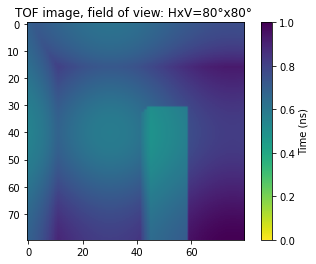

In [5]:
print('Max Depth =',max_depth)
plt.imshow(tof_photo(), cmap='viridis_r',vmin=0,vmax=1)
cbar=plt.colorbar(orientation='vertical')
cbar.set_label('Time (ns)')
plt.title('TOF image, field of view: HxV=80°x80° ')

### Photon gun

#### For simplicity, we assume that photons travel within the environment and they are reflected by the walls in a *mirror* fashion; that is, they experience specular reflection with 100% reflectivity. 

The code also allows for spread reflection (see below)

<center><img src="https://rh6stzxdcl1wf9gj1fkj14uc-wpengine.netdna-ssl.com/wp-content/uploads/2019/12/WHTH_LIDAR_Pt2_Fig4-1.jpg" width=300>
Image source https://www.microcontrollertips.com/lidar-and-time-of-flight-part-2-operation/ </center>

We record the arrival time to the detector and form a histogram.

The idea is to see if find regions of the histogram having information about the object alone, the background (far wall from the detector), and the environment. 

### 3d image handling
3D images are saved as npy files

In [12]:
# Visualise photon path
# I first initialize the parameters

# Number of photons 
nphot = 10000

# Mean free path (a.u.). This is the path the wave travels before the next iteration of the algorithm.  
l = 0.2

# Define object positions: the square will move in a grid of nx x ny
# points. 
nx = 3
ny = 3
nz = 1

# Array of random numbers used for the emission angles of the waves. 
# This angle is angle within [-67.5,67.5] deg (i.e. [-0.75pi/2,0.75pi/2] rad). 
# Theta is the angle in th x-y plane (azimuth)
theta0 = 0.75*np.pi*(np.random.rand(nphot)-0.5)

# Phi is the angle subtended between a vector in x-y-z and the x-y plane (altitude)
phi0 = 0.75*np.pi*(np.random.rand(nphot)-0.5)

######For training/validation data ################################
# xob_list = (0.5+sensx)+((xend-Lx)-(0.5+sensx))*np.random.rand(nx) # min + (max-min) * rand[0,1]
#                                                # gives random numbers in range[min,max] 
# yob_list = -yend + ((yend-Ly)-(-yend))*np.random.rand(ny)
# zob_list = -zend*np.ones(nz) 
###################################################################

#######For testing data############################################
xob_list = (0.5+sensx)+((xend-Lx)-(0.5+sensx))*np.linspace(0,1,nx)  
yob_list = -yend + ((yend-Ly)-(-yend))*np.linspace(0,1,ny)
zob_list = -zend*np.ones(1) #box on floor, in this case make nz=1
###################################################################
   
max_count = 150;  #Maximum time of measurement
n_n = 5; # Maximum number of relexions allowed before the wave is absorbed. 
         # After that, the wave dissapears and we jump to the next one. 
         # (set to unreasonably high number e.g. 10000 to practically avoid
         # reaching the scattering limit before you reach the max_count)
    
rw = 1 # Reflectivity of wall. A photon hitting a wall of reflectivity e.g.0.8 has 80%
           # chance to be reflected, 20% chance to be absorbed/transmitted (eliminated) 
ro = 1 #Reflectivity of object.

processed = 0
plt.style.use('default')

for i in range(nx):
    for j in range(ny):
        for k in range(nz):             
            # sensor is at (xsensi_i, 0, 0). Depth is encoded as: distance to sensor/maximum distance possible

            # UPDATE GLOBALS
            # Here I move the objects randomly in the room, keeping them on the floor. Maybe a regular x-y grid would be better
            xob_i = xob_list[i]
            yob_i = yob_list[j]
            zob_i = zob_list[k]


            nscatt_max = n_n+1

            #take a picture
            img = tof_photo()
            np.save('../data/tof_img_n{}x{}y{}z{}ro{}rw{}'.format(nscatt_max,i,j,k,ro,rw),img)

#                 fig = plt.figure()
#                 plt.imshow(img*max_depth)
#                 cbar=plt.colorbar()
#                 cbar.set_label('Depth [m]',rotation=270,labelpad=15)
#                 plt.show()

            # Arrival times of rays: this is where the arrival time of photons will be
            # stored. If the photon is not detected, arrival time is = 0.
            # I record the number of steps before the wave is detected. Knowing that
            # every step equals a path = l; then we can get the step time as l/c (where
            # c is the speed of the wave). 
            arr_path = np.zeros((nphot))

            for m in range(nphot):  

                # Initialize the wave emission and related parameters. 
                xphotpos_i = xsens_i # Instantenous position of the wave in x
                yphotpos_i = ysens_i # Instantenous position of the wave in y
                zphotpos_i = zsens_i # Instantenous position of the wave in y
                count = 0
                nscatt = 0
                extinction = False
                theta = theta0[m] # Azimuthal emission angle
                phi = phi0[m] # Altitude emission angle

#                     # If we un-comment the part commented with Ctrl-/ below, we can see the wave
#                     # trajectories and bouncing in the scene.   

#                     fig = plt.figure(figsize=(8,6),dpi=60)
#                     ax = fig.gca(projection="3d")
#                     X, Y, Z = cuboid_data((xsens_i,ysens_i,zsens_i), (sensx,sensy,sensz))
#                     surf = ax.plot_surface(X, Y, Z,color='red',label='sensor',alpha=0.2)  #sensor
#                     surf._facecolors2d=surf._facecolors3d
#                     surf._edgecolors2d=surf._edgecolors3d
#                     X, Y, Z = cuboid_data((xob_i,yob_i,zob_i), (Lx,Ly,Lz))
#                     surf = ax.plot_surface(X, Y, Z,color='blue',label='object',alpha=0.2)  #object
#                     surf._facecolors2d=surf._facecolors3d
#                     surf._edgecolors2d=surf._edgecolors3d
#                     X, Y, Z = cuboid_data((0,-yend,-zend), (xend,2*yend,2*zend))
#                     surf = ax.plot_surface(X, Y, Z,color='grey',cmap='Accent',label='room',alpha=0.1)  #room
#                     surf._facecolors2d=surf._facecolors3d
#                     surf._edgecolors2d=surf._edgecolors3d
#                     ax.set_title('Ray reflection')
#                     pad = 0.2
#                     ax.set_xlim(xend+pad,0-pad)
#                     ax.set_ylim(-yend-pad,yend+pad)
#                     ax.set_zlim(-zend-pad,zend+pad)
#                     ax.set_ylabel('y (m)')
#                     ax.set_zlabel('z (m)')
#                     ax.set_xlabel('x (m)')
#                     ax.scatter(xphotpos_i,yphotpos_i,zphotpos_i,color='black',marker='x',s=25,label='emission point')  #photon leaving detector
#                     ax.legend()
#                     x_positions = []
#                     y_positions = []
#                     z_positions = []   






                while(1):

                    count = count + 1;
                    scatt_ang_theta = 0.0*np.pi*(np.random.rand(1)-0.5); # This will be added to the reflection angle
                                                   # to account for a bit of scattering instead 
                                                   # perfect reflection. Make scatt_ang = 0 for
                                                   # pure mirror reflection. 

                    scatt_ang_phi = 0.0*np.pi*(np.random.rand(1)-0.5); # This will be added to the reflection angle
                               # to account for a bit of scattering instead 
                               # perfect reflection. Make scatt_ang = 0 for
                               # pure mirror reflection. 

                    # Calculate next position of the ray
                    xphotpos_f = xphotpos_i + l*np.cos(theta); 
                    yphotpos_f = yphotpos_i + l*np.sin(theta);
                    zphotpos_f = zphotpos_i + l*np.sin(phi);

                    #Now we calculate eventual reflections everywhere

                    # Return to emitter/detector
                    if all((yphotpos_f > ysens_i, yphotpos_f < ysens_i + sensy)):
                        if all((zphotpos_f > zsens_i, zphotpos_f < zsens_i + sensz)):
                            if all((xphotpos_i > xsens_i + sensx, xphotpos_f < xsens_i + sensx)): 
                                break 

                    # Near and far wall
                    if any((xphotpos_f > xf, xphotpos_f < xn)):                                   
                        if np.random.rand(1)>rw:
                            extinction = True     
                            break
                        else:
                            theta = np.pi-theta + scatt_ang_theta
                            phi = np.pi-phi + scatt_ang_phi
                            xphotpos_f = xphotpos_i + l*np.cos(theta); 
                            yphotpos_f = yphotpos_i + l*np.sin(theta);
                            zphotpos_f = zphotpos_i + l*np.sin(phi);
                            nscatt = nscatt + 1; 

                    # left and right wall
                    if any((yphotpos_f > yr, yphotpos_f < yl)):
                        if np.random.rand(1)>rw:
                            extinction = True     
                            break
                        else:
                            theta = -theta + scatt_ang_theta
                            phi = np.pi-phi + scatt_ang_phi
                            xphotpos_f = xphotpos_i + l*np.cos(theta); 
                            yphotpos_f = yphotpos_i + l*np.sin(theta);  
                            zphotpos_f = zphotpos_i + l*np.sin(phi);
                            nscatt = nscatt + 1; 


                    # Top and bottom wall
                    if any((zphotpos_f > zt, zphotpos_f < zb)):                               
                        if np.random.rand(1)>rw:
                            extinction = True                             
                            break
                        else:
                            theta = theta + scatt_ang_theta
                            phi = -phi + scatt_ang_phi
                            xphotpos_f = xphotpos_i + l*np.cos(theta); 
                            yphotpos_f = yphotpos_i + l*np.sin(theta);
                            zphotpos_f = zphotpos_i + l*np.sin(phi);
                            nscatt = nscatt + 1; 



                    # Object: near and front walls
                    if all((yphotpos_f > yob_i, yphotpos_f < yob_i + Ly)):
                        if all((zphotpos_f > zob_i, zphotpos_f < zob_i + Lz)):
                            if any((all((xphotpos_i < xob_i, xphotpos_f > xob_i)),
                                    all((xphotpos_i > xob_i + Lx, xphotpos_f < xob_i + Lx)))):
                                if np.random.rand(1)>ro:
                                    extinction = True                                     
                                    break
                                else:
                                    theta = np.pi-theta + scatt_ang_theta
                                    phi = np.pi-phi + scatt_ang_phi
                                    xphotpos_f = xphotpos_i + l*np.cos(theta); 
                                    yphotpos_f = yphotpos_i + l*np.sin(theta);
                                    zphotpos_f = zphotpos_i + l*np.sin(phi);
                                    nscatt = nscatt + 1; 

                    # Object: left and right walls
                    if all((xphotpos_f > xob_i, xphotpos_f < xob_i + Lx)):
                        if all((zphotpos_f > zob_i, zphotpos_f < zob_i + Lz)):
                            if any((all((yphotpos_i < yob_i, yphotpos_f > yob_i)),
                                    all((yphotpos_i > yob_i + Ly, yphotpos_f < yob_i + Ly)))):
                                if np.random.rand(1)>ro:
                                    extinction = True                                     
                                    break
                                else:
                                    theta = -theta + scatt_ang_theta
                                    phi = np.pi-phi + scatt_ang_phi
                                    xphotpos_f = xphotpos_i + l*np.cos(theta); 
                                    yphotpos_f = yphotpos_i + l*np.sin(theta);  
                                    zphotpos_f = zphotpos_i + l*np.sin(phi);
                                    nscatt = nscatt + 1; 


                    # Object: top and bottom walls
                    if all((xphotpos_f > xob_i, xphotpos_f < xob_i + Lx)):
                        if all((yphotpos_f > yob_i, yphotpos_f < yob_i + Ly)):
                            if any((all((zphotpos_i < zob_i, zphotpos_f > zob_i)),
                                    all((zphotpos_i > zob_i + Lz, zphotpos_f < zob_i + Lz)))):
                                if np.random.rand(1)>ro:
                                    extinction = True                
                                    break
                                else:
                                    theta = theta + scatt_ang_theta
                                    phi = -phi + scatt_ang_phi
                                    xphotpos_f = xphotpos_i + l*np.cos(theta); 
                                    yphotpos_f = yphotpos_i + l*np.sin(theta);
                                    zphotpos_f = zphotpos_i + l*np.sin(phi);
                                    nscatt = nscatt + 1; 


                    # Break if the number of maximum scattering events is reached 
                    if nscatt > nscatt_max:
                        break

                    # Break if the maximum time exceeded 
                    if count > max_count:
                        break

                    # Calculate new angles and reset positions for next stage
                    theta = np.arctan2((yphotpos_f-yphotpos_i),(xphotpos_f-xphotpos_i))
                    xphotpos_i = xphotpos_f; 
                    yphotpos_i = yphotpos_f; 
                    zphotpos_i = zphotpos_f;


                    # Plot the scattering process. Uncomment parts below with Ctrl-/ to see simulation. 
#                         x_positions.append(xphotpos_f)
#                         y_positions.append(yphotpos_f)
#                         z_positions.append(zphotpos_f)
#                         ax.view_init(azim=count*2%360,elev=30+30*np.cos(count/20))
#                         ax.scatter(xphotpos_f,yphotpos_f,zphotpos_f,color='red',linewidth=0.5)
#                         display.clear_output(wait=True)        
#                         display.display(plt.gcf())
#                     ax.legend()
#                     plt.show()
                count = count + (1+0.5*np.random.randn(1))[0] # BW = 4GHz > corresponds to 1/4*10^9 s IRF -> d = t*c = 7.5 cm.
                                                           # since this is a simulation, I'll add 10 cm (0.5*mean free path)
                                                           # with a mean 20cm (1 mean free path) worth of delay 
                if count > max_count or nscatt > nscatt_max or extinction == True:
                    arr_path[m] = float('NaN'); # arr_path is the path length in units of mean free paths that the photon travelled
                else:
                    arr_path[m] = count

            #Save time trace
            np.save('../data/arrival_time_n{}x{}y{}z{}ro{}rw{}'.format(nscatt_max,i,j,k,ro,rw),arr_path)
            processed = processed+1
            print('processed',processed,'examples')
            display.clear_output(wait=True)
print(processed)

9


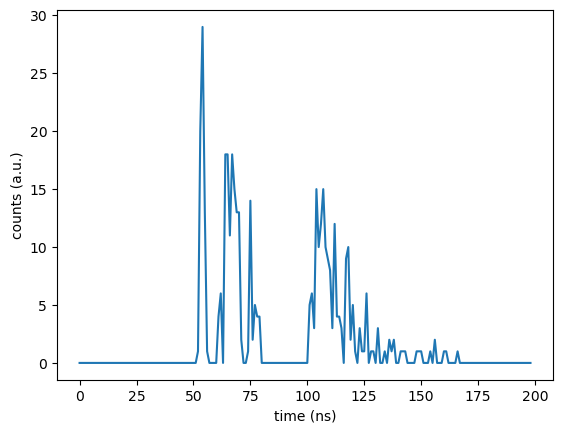

In [16]:
#Check temporal histogram
arr_time = 1e9*(arr_path*0.2/(3e8)) # time = distance travelled/speed of light. Convert to units of ns. 
histogram, bin_edges = np.histogram(arr_time,bins=np.linspace(0,100,200))
plt.plot(histogram)
plt.xlabel('time (ns)')
plt.ylabel('counts (a.u.)')
plt.show()

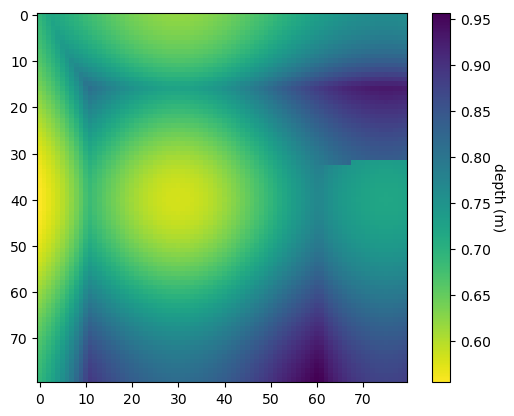

In [17]:
#Check depth map
plt.imshow(img,cmap='viridis_r')
cbar = plt.colorbar()
cbar.set_label('depth (m)', labelpad=10, rotation=270)
plt.show()